$Q(s, a; \theta) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q(s', a'; \theta') \middle| s, a \right]$

* Q 是状态 s 和动作 a 下的 Q 值，参数 θ 表示 Q 网络的参数。
* $r_t$ 是当前步的奖励。
* $\gamma$ 是折扣因子，让未来的收益打折
* $max_{a'} Q$ 是下一步状态 $s'$中最大的 Q 值，$a'$ 是 $s'$ 中所有动作

Q 度量的是当前状态和动下下，且未来总用最优动作带来的回报折现

学习更新的方法

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right)$

## 用神经网络代替 Q

In [6]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import random
from collections import deque

In [7]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.dropout1 = nn.Dropout(0.2)  # Add dropout after first layer
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.2)  # Add dropout after second layer
        self.fc3 = nn.Linear(128, n_actions)

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        layer1 = self.dropout1(layer1)  # Apply dropout after activation
        layer2 = F.leaky_relu(self.fc2(layer1), negative_slope=0.01)
        layer2 = self.dropout2(layer2)  # Apply dropout after activation
        actions = self.fc3(layer2)
        return actions

In [8]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99, epsilon=1.0, ep_dec=1e-5, ep_min=0.01, mem_size=100000, batch_size=64):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = ep_dec
        self.eps_min = ep_min
        self.n_action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.memory = deque(maxlen=mem_size)

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.append((state, action, reward, state_, done))

    def sample_memory(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, states_, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_), np.array(dones)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float32).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)

        return action
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        self.Q.optimizer.zero_grad()
        states, actions, rewards, states_, dones = self.sample_memory()

        states = T.tensor(states, dtype=T.float32).to(self.Q.device)
        actions = T.tensor(actions, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.Q.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.Q.device)
        dones = T.tensor(dones, dtype=T.bool).to(self.Q.device)

        q_pred = self.Q.forward(states)[range(self.batch_size), actions]
        q_next = self.Q.forward(states_).max(dim=1)[0]
        q_next[dones] = 0.0

        q_target = rewards + self.gamma * q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [9]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    # plt.savefig(filename)
    return plt

In [15]:
env = gym.make('CartPole-v1')

In [18]:
env.action_space.n

2

In [45]:
obs_, reward, terminated, truncated, info = env.step(action)
obs_, reward, terminated, truncated, info

(array([ 0.02288327, -0.19105881,  0.02033674,  0.3403878 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [57]:
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
obs = env.reset()
action = agent.choose_action(obs)
obs_, reward, terminated, truncated, info = env.step(action)
obs[0],action,obs_, reward, terminated, truncated, info



(array([-0.00490873, -0.01135814,  0.01391778, -0.01364402], dtype=float32),
 0,
 array([-0.00513589, -0.2066769 ,  0.0136449 ,  0.28339744], dtype=float32),
 1.0,
 False,
 False,
 {})

In [16]:
env = gym.make('CartPole-v1')
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
n_games = 100000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.store_transition(obs, action, reward, obs_, terminated or truncated)
        agent.learn()
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        if i % 1000 == 0:
            print(f'episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}')

episode 0 score 43.0 average score 43.0 epsilon 1.0
episode 1000 score 15.0 average score 25.31 epsilon 0.7649900000010695
episode 2000 score 17.0 average score 25.31 epsilon 0.5299700000021391
episode 3000 score 13.0 average score 27.82 epsilon 0.26187000000203736
episode 4000 score 24.0 average score 35.16 epsilon 0.01
episode 5000 score 63.0 average score 38.42 epsilon 0.01
episode 6000 score 54.0 average score 44.13 epsilon 0.01
episode 7000 score 78.0 average score 42.16 epsilon 0.01
episode 8000 score 17.0 average score 45.09 epsilon 0.01
episode 9000 score 33.0 average score 45.63 epsilon 0.01
episode 10000 score 22.0 average score 53.34 epsilon 0.01
episode 11000 score 27.0 average score 55.48 epsilon 0.01
episode 12000 score 26.0 average score 64.65 epsilon 0.01
episode 13000 score 149.0 average score 69.86 epsilon 0.01
episode 14000 score 20.0 average score 70.44 epsilon 0.01
episode 15000 score 18.0 average score 76.73 epsilon 0.01
episode 16000 score 85.0 average score 69.7

<module 'matplotlib.pyplot' from 'd:\\ProgramData\\Anaconda3\\envs\\py310\\lib\\site-packages\\matplotlib\\pyplot.py'>

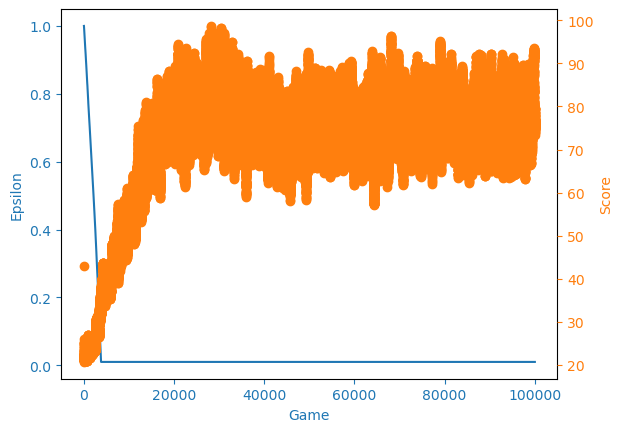

In [17]:
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)